In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [3]:
data_1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
data_1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
data_2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data_2.head()

,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1


In [5]:
data = pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [7]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

(-0.5, 999.5, 499.5, -0.5)

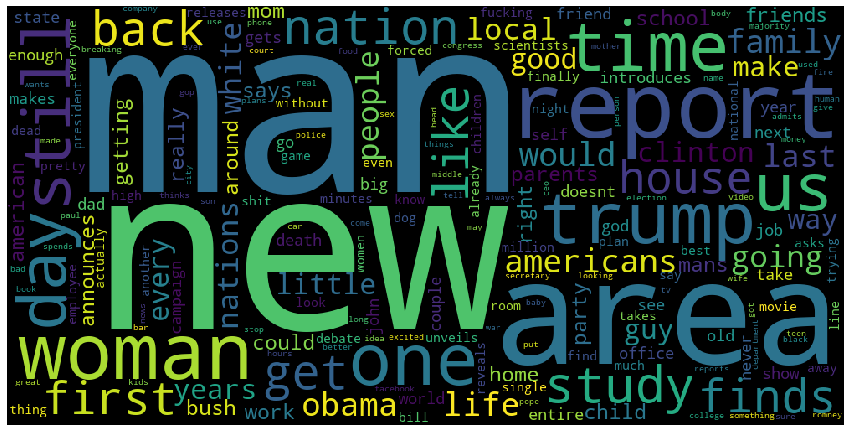

In [8]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [9]:
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(0.2 * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [15]:
print('Shape of X_train_pad:', lines_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


In [16]:
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = "O:\Glove"
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [17]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24993


In [19]:
print(embeddings_index.get("help"))

[-0.2272     0.41578    0.035985  -0.22895    0.13481   -0.12407
 -0.56653   -0.32096    0.16223   -0.024273  -0.033683  -0.4281
 -0.043623  -0.18682   -0.29002   -0.2464     0.51505   -0.27678
 -0.97691    0.6466    -0.2955    -0.34955    0.0085932  0.17147
 -0.24341    0.018099  -0.57991   -0.68634    0.29723   -0.19539
 -0.39285    0.55418   -0.11855    0.40271   -0.24441    0.13792
  0.14396    0.15116    0.19257   -0.095074  -0.59663   -0.27685
 -0.43814   -0.98947   -0.52515    0.52006   -0.4445    -0.23366
 -0.21019   -0.9059    -0.78404    0.11093    0.09208    1.2145
  0.52067   -2.4821    -0.17693   -0.94136    1.8578     0.17312
 -0.32761    0.45067   -0.092353   0.11201    0.50869    0.52743
 -0.075203   0.73518    0.40716   -0.74727    0.60342   -0.69189
 -0.56087   -0.87252    0.56949    0.35642   -0.25138    0.37888
 -0.68022    0.19444    0.92435    0.5161    -0.62632   -0.16946
 -1.825      0.23406    0.31977    0.76773   -0.83824   -0.38335
 -0.037695  -0.053895   0.1

In [20]:
embedding_matrix[word_index.get("help")]

array([-0.2272    ,  0.41578001,  0.035985  , -0.22894999,  0.13481   ,
       -0.12407   , -0.56652999, -0.32095999,  0.16223   , -0.024273  ,
       -0.033683  , -0.42809999, -0.043623  , -0.18682   , -0.29001999,
       -0.2464    ,  0.51504999, -0.27678001, -0.97691   ,  0.64660001,
       -0.29550001, -0.34955001,  0.0085932 ,  0.17147   , -0.24341001,
        0.018099  , -0.57990998, -0.68633997,  0.29723001, -0.19539   ,
       -0.39285001,  0.55418003, -0.11855   ,  0.40270999, -0.24440999,
        0.13792001,  0.14396   ,  0.15116   ,  0.19257   , -0.095074  ,
       -0.59662998, -0.27684999, -0.43814   , -0.98947001, -0.52515   ,
        0.52006   , -0.4445    , -0.23366   , -0.21019   , -0.9059    ,
       -0.78403997,  0.11093   ,  0.09208   ,  1.21449995,  0.52067   ,
       -2.48210001, -0.17693   , -0.94136   ,  1.85780001,  0.17312001,
       -0.32760999,  0.45067   , -0.092353  ,  0.11201   ,  0.50869   ,
        0.52743   , -0.075203  ,  0.73518002,  0.40716001, -0.74

In [21]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           2865800   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,908,105
Trainable params: 42,305
Non-trainable params: 2,865,800
_________________________________________________________________
None


In [ ]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, callbacks=[checkpoint], validation_split=0.2)

Train on 35410 samples, validate on 8853 samples
Epoch 1/25
35410/35410 [==============================] - 293s 8ms/step - loss: 0.5837 - acc: 0.6947 - val_loss: 0.5071 - val_acc: 0.7585
Epoch 2/25
35410/35410 [==============================] - 266s 8ms/step - loss: 0.5173 - acc: 0.7490 - val_loss: 0.4598 - val_acc: 0.7845
Epoch 3/25
35410/35410 [==============================] - 289s 8ms/step - loss: 0.4841 - acc: 0.7696 - val_loss: 0.4508 - val_acc: 0.7832
Epoch 4/25
35410/35410 [==============================] - 252s 7ms/step - loss: 0.4616 - acc: 0.7834 - val_loss: 0.4155 - val_acc: 0.8099
Epoch 5/25
35410/35410 [==============================] - 258s 7ms/step - loss: 0.4443 - acc: 0.7916 - val_loss: 0.3997 - val_acc: 0.8170
Epoch 6/25
35410/35410 [==============================] - 262s 7ms/step - loss: 0.4314 - acc: 0.8030 - val_loss: 0.3866 - val_acc: 0.8234
Epoch 7/25
35410/35410 [==============================] - 293s 8ms/step - loss: 0.4173 - acc: 0.8097 - val_loss: 0.3887 - v

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [2]:
model = load_model('model-021.model')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [10]:
model.evaluate(X_test_pad, y_test)

11065/11065 [==============================] - 14s 1ms/step


[0.23842658418311935, 0.9103479385375977]

In [11]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [1]:
predict_sarcasm("")

NameError: name 'predict_sarcasm' is not defined